In [ ]:
pip install -U  finance-datareader # type: ignore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # pandas 명시적 import 필요
import FinanceDataReader as fdr # type: ignore
import random
import seaborn as sns
from tqdm import tqdm

# 우리가 만든 모듈들 임포트
# (data_process.py에 clean_price_data, log_data가 있다고 가정)
from base.data_process import *
from diffusion_config import DiffusionConfig
from diffusion_factor_model_en_decoder import Encoder, Decoder
from time_dynamics import TemporalDynamics
from base.noise import GaussianDiffusion
from base.pca import PCA
from base.loss_functions import MSE_Loss

# ---------------------------------------------------------
# 1. 설정 및 장치 초기화
# ---------------------------------------------------------
config = DiffusionConfig(project_name='1' ,experiment_name='1')

# [안전장치] Config에 device가 없으면 여기서 직접 설정
if hasattr(config, 'device'):
    device = config.device
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device set to: {device}")


config_dict = config.to_dict()

In [30]:
# ---------------------------------------------------------
# 2. 데이터 다운로드 설정
# ---------------------------------------------------------
# 일단 목표 개수는 config에서 가져오되, 나중에 업데이트할 예정
config.num_assets = 300
TARGET_N_STOCKS = config.num_assets
START_DATE = '2010-01-01'
END_DATE = '2025-12-31'

# ---------------------------------------------------------
# 3. S&P 500 종목 리스트 가져오기
# ---------------------------------------------------------
print("S&P 500 종목 리스트를 불러오는 중...")
try:
    sp500 = fdr.StockListing('S&P500')
    all_tickers = sp500['Symbol'].tolist()
    print(f"총 {len(all_tickers)}개의 종목을 찾았습니다.")
except Exception as e:
    print(f"S&P500 리스트 로드 실패 (인터넷 연결 확인 필요): {e}")
    # 테스트용 더미 리스트 (실패 시 비상용)
    all_tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'TSLA', 'META', 'BRK-B', 'LLY', 'V']

# ---------------------------------------------------------
# 4. 랜덤하게 n개 뽑기
# ---------------------------------------------------------
if TARGET_N_STOCKS > len(all_tickers):
    selected_tickers = all_tickers
else:
    selected_tickers = random.sample(all_tickers, TARGET_N_STOCKS)

print(f"다운로드 시도할 종목 수: {len(selected_tickers)}")
print(f"예시: {selected_tickers[:5]} ...")

# ---------------------------------------------------------
# 5. 데이터 다운로드 및 병합
# ---------------------------------------------------------
close_data_dict = {}

print("데이터 다운로드 시작...")
for ticker in tqdm(selected_tickers):
    try:
        df = fdr.DataReader(ticker, START_DATE, END_DATE)

        # 데이터가 있고, 결측치가 너무 많지 않은 경우에만 추가
        if not df.empty and 'Close' in df.columns:
            close_data_dict[ticker] = df['Close']

    except Exception as e:
        print(f"Error fetching {ticker}: {e}")
        continue

# ---------------------------------------------------------
# 6. DataFrame 생성 및 전처리
# ---------------------------------------------------------
price_df = pd.DataFrame(close_data_dict)

print(f"\n[결측치 처리 전] Shape: {price_df.shape}")

# [Step 1] Null이 특정 개수(10개)를 초과하는 종목(Column) 제거
null_threshold = 10
null_counts = price_df.isnull().sum()

# Null이 기준치 이하인 우량 종목들만 남김
valid_tickers = null_counts[null_counts <= null_threshold].index
dropped_tickers = list(set(price_df.columns) - set(valid_tickers))

price_df = price_df[valid_tickers]

print(f" -> Null {null_threshold}개 초과 종목 {len(dropped_tickers)}개 제거됨")
if len(dropped_tickers) > 0:
    print(f"    (제거된 종목 예시: {dropped_tickers[:5]} ...)")

# [Step 2] 남은 결측치 채우기 (Interpolate -> ffill -> bfill 순서 권장)
# 1. interpolate: 중간에 빈 구멍은 선형 보간으로 부드럽게 연결
price_df = price_df.interpolate(method='linear', limit_direction='both')

# 2. ffill: 앞의 데이터로 뒤를 채움 (주말/공휴일 등)
price_df = price_df.ffill()

# 3. bfill: 맨 앞부분이 비어있을 경우 뒤의 데이터로 채움
price_df = price_df.bfill()

print(f"[결측치 처리 후] Shape: {price_df.shape}")
print(f"남은 Null 개수: {price_df.isnull().sum().sum()} (0이어야 함)")

# 로그 수익률 변환
ln_price, ln_price_diff = log_data(price_df)
ln_price = ln_price.dropna()
ln_price_diff = ln_price_diff.dropna()


# ---------------------------------------------------------
# 7. [CRITICAL] Config 업데이트 (실제 데이터 개수에 맞춤)
# ---------------------------------------------------------
actual_n_stocks = ln_price_diff.shape[1]

if actual_n_stocks != config.num_assets:
    print(f"\n[주의] 요청한 종목 수({config.num_assets})와 다운로드 성공한 수({actual_n_stocks})가 다릅니다.")
    print(f"Config.num_assets를 {actual_n_stocks}로 자동 업데이트합니다.")
    config.num_assets = actual_n_stocks

    # [Tip] 만약 num_factors가 종목 수보다 크면 에러 나므로 체크
    if config.num_factors > actual_n_stocks:
        print(f"Warning: 팩터 개수({config.num_factors})가 종목 수보다 많습니다. 절반으로 조정합니다.")
        config.num_factors = actual_n_stocks // 2

# ---------------------------------------------------------
# 8. 최종 확인
# ---------------------------------------------------------
print("-" * 50)
print(f"[완료] 데이터프레임 생성됨.")
print(f"Price Data Shape: {ln_price.shape} (Row: 날짜, Col: 종목)")
print(f"Diff Data Shape: {ln_price_diff.shape} (Input Data)")
print(f"Config Num Assets: {config.num_assets}")
print("-" * 50)

# 결과 확인
ln_price_diff.head()

S&P 500 종목 리스트를 불러오는 중...
총 503개의 종목을 찾았습니다.
다운로드 시도할 종목 수: 300
예시: ['HWM', 'HBAN', 'ETN', 'ORCL', 'MAA'] ...
데이터 다운로드 시작...


 51%|█████▏    | 154/300 [00:29<00:24,  6.08it/s]

Error fetching BFB: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/BFB?period1=1262304000&period2=1767139200&interval=1d&includeAdjustedClose=true


100%|██████████| 300/300 [00:56<00:00,  5.26it/s]


[결측치 처리 전] Shape: (4023, 299)
 -> Null 10개 초과 종목 46개 제거됨
    (제거된 종목 예시: ['APO', 'LYB', 'META', 'DDOG', 'PAYC'] ...)
[결측치 처리 후] Shape: (4023, 253)
남은 Null 개수: 0 (0이어야 함)

[주의] 요청한 종목 수(300)와 다운로드 성공한 수(253)가 다릅니다.
Config.num_assets를 253로 자동 업데이트합니다.
--------------------------------------------------
[완료] 데이터프레임 생성됨.
Price Data Shape: (4023, 253) (Row: 날짜, Col: 종목)
Diff Data Shape: (4022, 253) (Input Data)
Config Num Assets: 253
--------------------------------------------------


,HBAN,ETN,ORCL,MAA,KLAC,GOOG,ADBE,TDY,CTRA,AZO,...,L,MTD,CINF,ACN,MO,LLY,ED,DPZ,WTW,TSN
2010-01-05,0.021506,-0.005925,-0.001208,-0.000830,-0.011167,-0.004413,0.016313,-0.005076,-0.001299,-0.008388,...,0.005365,-0.025308,0.000377,0.006161,0.000505,-0.017744,-0.013087,0.009174,-0.002244,0.018617
2010-01-06,0.026248,-0.004389,-0.014611,0.003317,-0.003842,-0.025532,-0.002124,0.001780,-0.004341,-0.009425,...,0.006931,-0.007699,0.002261,0.010575,0.014540,0.007361,0.010660,0.028139,0.015971,0.049286
2010-01-07,0.105620,0.014658,-0.003276,0.004750,0.005484,-0.023555,-0.019595,0.012871,-0.008959,0.013182,...,0.007411,-0.017469,0.003757,-0.000935,-0.001494,-0.005091,-0.003541,0.039178,-0.002952,0.017405
2010-01-08,-0.016452,0.022198,0.012230,-0.006614,0.014928,0.013243,-0.005436,0.010476,-0.002197,-0.012925,...,-0.000791,0.016784,-0.003380,-0.003986,0.002489,-0.007685,0.003099,0.000000,-0.001109,-0.002253
2010-01-11,0.025732,0.044708,0.000405,0.005171,-0.004320,-0.001513,-0.013169,0.016245,-0.026074,0.001287,...,0.000791,0.008870,0.007496,-0.000940,0.007431,0.013621,0.012518,0.007443,0.009939,-0.013626


In [88]:
# ---------------------------------------------------------
# 1. 데이터 전처리 (To_TensorSet 실행)
# ---------------------------------------------------------
print("데이터 텐서 변환 및 분할 시작...")

# (1) 프로세서 인스턴스 생성 (Config 필요)
tensor_processor = To_TensorSet(config)

# (2) process 메서드 호출 (DataFrame -> Dictionary)
# diffusion_data_dict['train']['FULL']에 (N, d, T) 형태의 텐서가 들어있습니다.
diffusion_data_dict = tensor_processor.process(ln_price_diff)

print("텐서 변환 완료.")



데이터 텐서 변환 및 분할 시작...
텐서 변환 완료.


In [92]:
# 기존 코드: diffusion_data_dict = tensor_processor.process(ln_price_diff)

# [수정] 스케일링 팩터 정의
SCALE_FACTOR = 100.0  # 데이터를 100배 키움 (0.01 -> 1.0)

# 1. 딕셔너리 안의 모든 텐서에 100을 곱해줍니다.
print(f"Applying Scale Factor: x {SCALE_FACTOR}")

for key in ['test', 'train']:
    # BTD, BDT 리스트/텐서 처리
    if isinstance(diffusion_data_dict[key]['BDT'], list):
        diffusion_data_dict[key]['BDT'] = [t * SCALE_FACTOR for t in diffusion_data_dict[key]['BDT']]
    else:
        diffusion_data_dict[key]['BDT'] = diffusion_data_dict[key]['BDT'] * SCALE_FACTOR

    if isinstance(diffusion_data_dict[key]['BTD'], list):
        diffusion_data_dict[key]['BTD'] = [t * SCALE_FACTOR for t in diffusion_data_dict[key]['BTD']]
    else:
        diffusion_data_dict[key]['BTD'] *= SCALE_FACTOR

# FULL 데이터도 스케일링 (PCA용)
diffusion_data_dict['train']['FULL'] *= SCALE_FACTOR

Applying Scale Factor: x 100.0


샘플 데이터 값 확인: 0.8275

PCA 분석 시작... (Input Shape: torch.Size([133, 253, 30]))
Start to conduct the PCA. Please check the data's shape is correctly setted for your purpose.
[PCA Finish] Used top-k=16 factors.
Top 5 Eigenvalues: [351.0568542480469, 36.6240348815918, 33.47087860107422, 19.27098274230957, 16.436656951904297]
The returns : cov_full / eig_vals_arranged / diag_variances
--------------------------------------------------
PCA 완료. 추출된 잔차 분산(Variance) 개수: 253
상위 5개 고유값(Eigenvalues): [351.05685   36.624035  33.47088   19.270983  16.436657]
첫 5개 종목의 잔차 분산: [0.9952626 1.0007877 2.0801363 0.6108482 1.5895953]
--------------------------------------------------


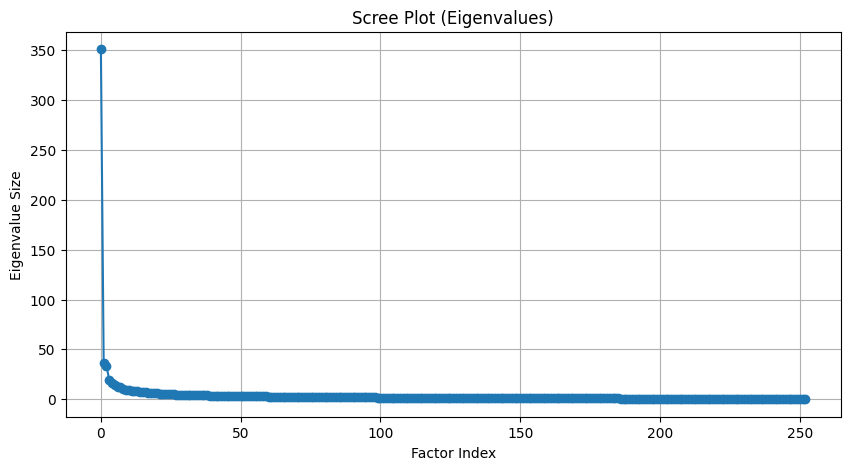

In [105]:
# ---------------------------------------------------------
# 2. PCA 수행 (Train Set 전체 데이터 사용)
# ---------------------------------------------------------
# PCA는 학습 데이터 전체의 분포를 봐야 하므로 배치로 나누기 전의 'FULL' 데이터를 사용합니다.
train_full_data = diffusion_data_dict['train']['FULL']

sample_val = diffusion_data_dict['train']['FULL'][0, 1, 0].item()
print(f"샘플 데이터 값 확인: {sample_val:.4f}")

# GPU 사용 가능하다면 GPU로 이동 (연산 가속)
train_full_data = train_full_data.to(device)

print(f"\nPCA 분석 시작... (Input Shape: {train_full_data.shape})")

# PCA 함수 호출
# k = config.num_factors (예: 10개 팩터)
cov_full, eig_vals, diag_variances = PCA(train_full_data, k=config.num_factors)

# ---------------------------------------------------------
# 3. 결과 저장 및 확인
# ---------------------------------------------------------
# [중요] diag_variances는 나중에 Loss Function에서 가중치로 계속 쓰이므로
# 미리 device에 올려두고 변수로 저장해둡니다.
diag_variances = diag_variances.to(device)

print("-" * 50)
print(f"PCA 완료. 추출된 잔차 분산(Variance) 개수: {len(diag_variances)}")
print(f"상위 5개 고유값(Eigenvalues): {eig_vals[:5].cpu().numpy()}") # 확인용 출력
print(f"첫 5개 종목의 잔차 분산: {diag_variances[:5].cpu().numpy()}")
print("-" * 50)

# 시각화 (선택 사항: 고유값 감소 그래프 Scree Plot)


plt.figure(figsize=(10, 5))
plt.plot(eig_vals.cpu().numpy(), marker='o')
plt.title("Scree Plot (Eigenvalues)")
plt.xlabel("Factor Index")
plt.ylabel("Eigenvalue Size")
plt.grid(True)
plt.show() #

모델 초기화 및 GPU 설정 중...
Current Device: cpu

학습 시작...
[Epoch 10/1000] Total: 3.209242 | Recon(R): 3.083104 | Latent(F): 1.261377
[Epoch 20/1000] Total: 2.877880 | Recon(R): 2.729159 | Latent(F): 1.487213
[Epoch 30/1000] Total: 2.737718 | Recon(R): 2.605908 | Latent(F): 1.318103
[Epoch 40/1000] Total: 2.442887 | Recon(R): 2.349643 | Latent(F): 0.932438
[Epoch 50/1000] Total: 2.742928 | Recon(R): 2.608382 | Latent(F): 1.345458
[Epoch 60/1000] Total: 2.735373 | Recon(R): 2.586547 | Latent(F): 1.488263
[Epoch 70/1000] Total: 2.507806 | Recon(R): 2.379641 | Latent(F): 1.281651
[Epoch 80/1000] Total: 2.608819 | Recon(R): 2.479378 | Latent(F): 1.294416
[Epoch 90/1000] Total: 2.357545 | Recon(R): 2.253098 | Latent(F): 1.044475
[Epoch 100/1000] Total: 2.438303 | Recon(R): 2.309390 | Latent(F): 1.289135
[Epoch 110/1000] Total: 2.533655 | Recon(R): 2.400171 | Latent(F): 1.334840
[Epoch 120/1000] Total: 2.648039 | Recon(R): 2.492913 | Latent(F): 1.551255
[Epoch 130/1000] Total: 2.313582 | Recon(R): 2

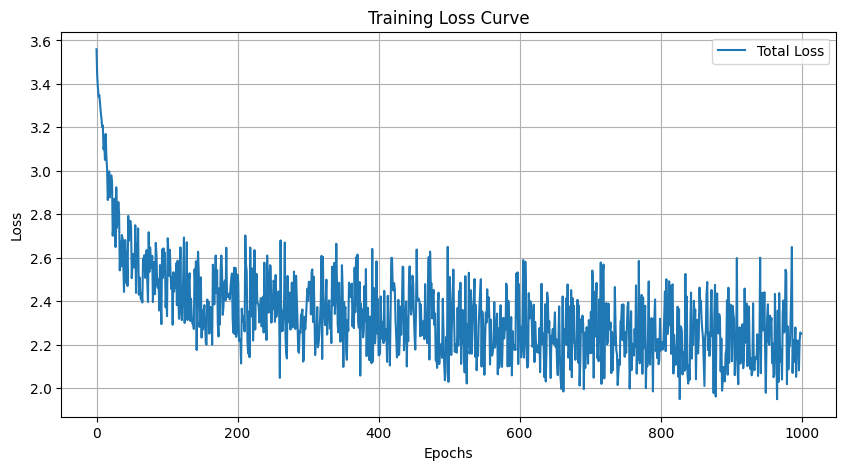

In [106]:
import itertools
#---------------------------------------------------------
# 1. 모델 및 설정 초기화 (Setup)
# ---------------------------------------------------------
print("모델 초기화 및 GPU 설정 중...")

# (1) 설정 및 장치
# config는 앞서 정의한 DiffusionConfig 객체여야 합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")

# (2) 모델 인스턴스 생성
# Encoder: (Batch, D, T) -> (Batch, k, T)
encoder = Encoder(input_dim=config.num_assets,
                  factor_dim=config.num_factors,
                  num_layers=2).to(device)

# Noise Generator: (Batch, k, T) -> (Batch, k, T)
# (파라미터 학습 X, 버퍼만 있음)
diffusion = GaussianDiffusion(config).to(device)

# Time Dynamics: (Batch, k, T) + t -> (Batch, k, T)
dynamics = TemporalDynamics(factor_dim=config.num_factors,
                            time_emb_dim=config.hidden_dim,
                            num_layers=4).to(device)

# Decoder: (Batch, k, T) -> (Batch, D, T)
decoder = Decoder(factor_dim=config.num_factors,
                  output_dim=config.num_assets,
                  num_layers=2).to(device)

# (3) Optimizer 설정

all_parameters = list(itertools.chain(
    encoder.parameters(),
    dynamics.parameters(),
    decoder.parameters()
))

optimizer = optim.AdamW(all_parameters, lr=1e-3, weight_decay=1e-5)

# (4) Loss Function 설정
# use_cov_weight=True -> PCA 잔차 분산 사용
loss_fn_R = MSE_Loss(use_cov_weight=True, prepared_var_mtx=True).to(device)
loss_fn_F = MSE_Loss(use_cov_weight=False).to(device) # 팩터는 단순 MSE

# PCA 결과인 잔차 분산을 GPU로 이동 (Loss 계산용)
diag_variances = diag_variances.to(device)

# ---------------------------------------------------------
# 2. 학습 루프 (Training Loop)
# ---------------------------------------------------------
print("\n학습 시작...")

# 데이터 로더 (List of Tensors from To_TensorSet)
train_loader = diffusion_data_dict['train']['BDT'] # (Batch, D, T) 형태

EPOCHS = 1000
loss_history = []

for epoch in range(EPOCHS):
    epoch_loss_total = 0.0
    epoch_loss_r = 0.0
    epoch_loss_f = 0.0

    # --- Batch Loop ---
    for batch_idx, real_data in enumerate(train_loader):
        # 1. 데이터 준비
        # real_data: (Batch, D, T) -> GPU 이동
        x_0 = real_data.to(device)
        batch_size = x_0.size(0)

        # Optimizer 초기화
        optimizer.zero_grad()

        # -------------------------------------------------
        # [Step 1] Encoder: Clean Data -> Clean Factor
        # -------------------------------------------------
        f_0 = encoder(x_0) # (B, k, T)

        # -------------------------------------------------
        # [Step 2] Diffusion: Clean Factor -> Noisy Factor
        # -------------------------------------------------
        # f_0에 노이즈 주입 (학습용 문제 출제)
        f_t, noise_z, t = diffusion(f_0)

        # -------------------------------------------------
        # [Step 3] Dynamics: Noisy Factor -> Predicted Factor
        # -------------------------------------------------
        # "노이즈 낀 f_t를 보고 원본 f_0를 맞춰봐"
        f_0_hat = dynamics(f_t, t)

        # -------------------------------------------------
        # [Step 4] Decoder: Predicted Factor -> Reconstructed Data
        # -------------------------------------------------
        # "복원된 팩터로 자산 가격 다시 그려봐"
        r_0_hat = decoder(f_0_hat)

        # -------------------------------------------------
        # [Step 5] Loss Calculation
        # -------------------------------------------------

        # (A) Reconstruction Loss (자산 복원)
        # PCA 잔차 분산(diag_variances)을 가중치로 사용
        loss_R = loss_fn_R(r_0_hat, x_0, var_mtx=diag_variances)

        # (B) Latent Consistency Loss (팩터 일관성)
        # Encoder가 만든 정답(f_0) vs Dynamics가 예측한 값(f_0_hat)
        loss_F = loss_fn_F(f_0_hat, f_0)

        # (C) Total Loss
        # lambda_f (팩터 로스 반영 비율, 조절 가능)
        lambda_f = 0.1
        total_loss = loss_R + (lambda_f * loss_F)

        # -------------------------------------------------
        # [Step 6] Backpropagation
        # -------------------------------------------------
        total_loss.backward()

        # Gradient Clipping (학습 안정성)
        torch.nn.utils.clip_grad_norm_(all_parameters, max_norm=1.0)

        optimizer.step()

        # 로그 기록
        epoch_loss_total += total_loss.item()
        epoch_loss_r += loss_R.item()
        epoch_loss_f += loss_F.item()

    # --- Epoch End ---
    # 평균 Loss 계산
    avg_total = epoch_loss_total / len(train_loader)
    avg_r = epoch_loss_r / len(train_loader)
    avg_f = epoch_loss_f / len(train_loader)
    loss_history.append(avg_total)

    if (epoch + 1) % 10 == 0:
        print(f"[Epoch {epoch+1}/{EPOCHS}] "
              f"Total: {avg_total:.6f} | Recon(R): {avg_r:.6f} | Latent(F): {avg_f:.6f}")

print("학습 완료.")

# ---------------------------------------------------------
# 3. 학습 결과 시각화 (Loss Curve)
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Total Loss')
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Test Set 평가 시작...


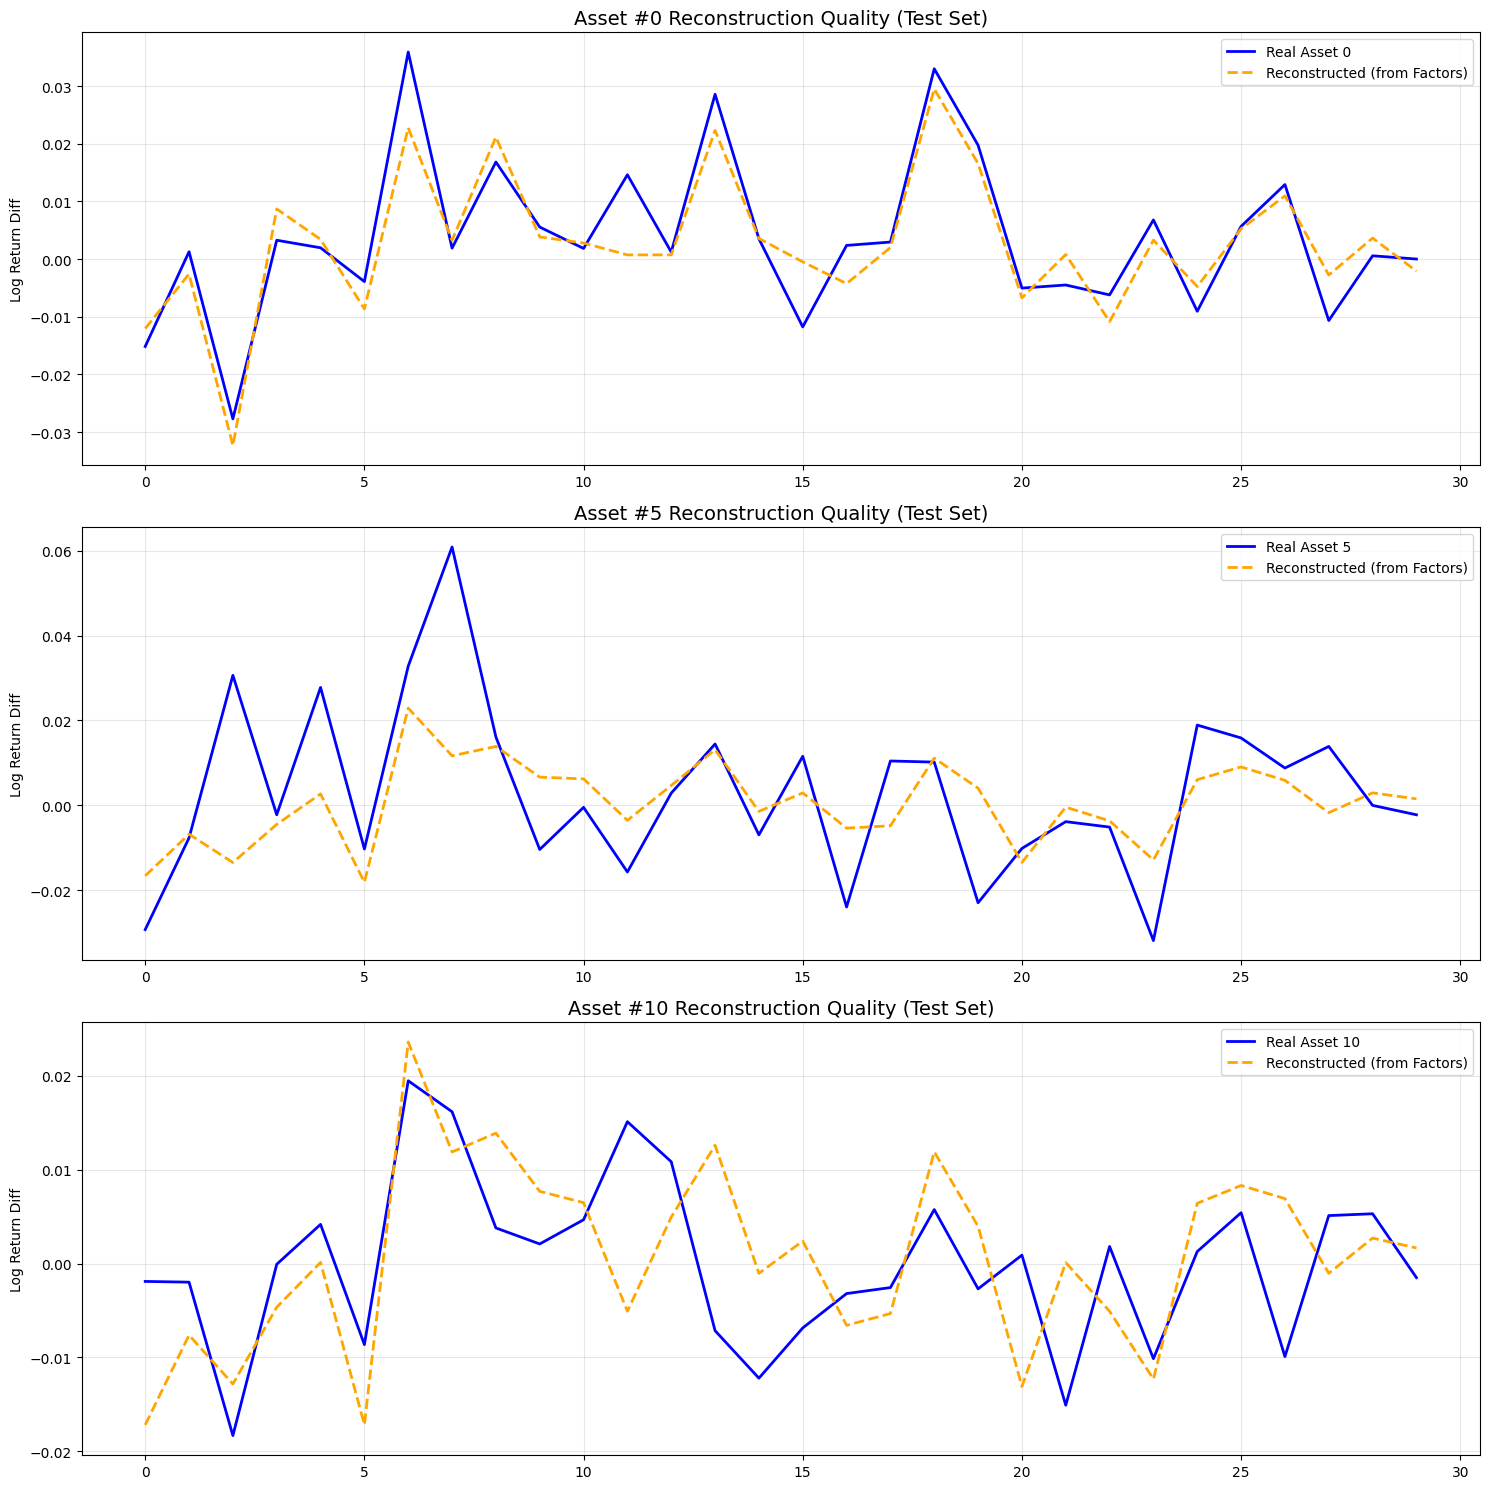

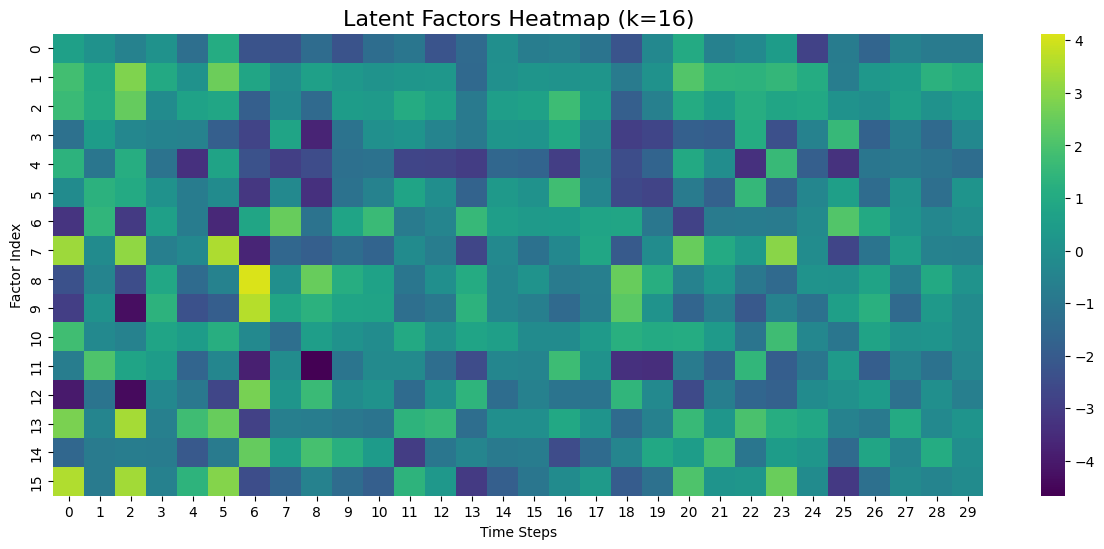


[Test Result]
Test Set MSE Loss: 0.00018888
해석: 이 값이 0에 가까울수록 모델이 팩터를 통해 시장을 완벽하게 설명한다는 뜻입니다.


In [107]:
def visualize_test_results(data_dict, encoder, decoder, dynamics, device, sample_indices=[0, 1, 2]):
    """
    Args:
        sample_indices: 시각화할 종목의 인덱스 리스트 (예: [0, 1, 2] -> 첫 3개 종목)
    """
    encoder.eval()
    decoder.eval()
    dynamics.eval()

    print("Test Set 평가 시작...")


    # 1. Test Data 가져오기
    # shape: (1, 1, D, T) -> (1, D, T)로 차원 축소
    test_data = data_dict['test']['BDT'].squeeze(0).to(device)

    # 2. 모델 통과 (Inference)
    with torch.no_grad():
        factors = encoder(test_data)
        reconstructed = decoder(factors)

    # CPU로 변환 & 스케일 원복 (나누기 100)
    # 입력 데이터도 100배 되어있으니 나눠주고, 복원된 것도 나눠줍니다.
    real_np = test_data.cpu().numpy().squeeze(0) / SCALE_FACTOR
    recon_np = reconstructed.cpu().numpy().squeeze(0) / SCALE_FACTOR
    factors_np = factors.cpu().numpy().squeeze(0)     # (k, T)

    T = real_np.shape[1]
    time_axis = np.arange(T)

    # -------------------------------------------------
    # 시각화 1: 자산 가격 복원 능력 (Real vs Recon)
    # -------------------------------------------------
    plt.figure(figsize=(15, 5 * len(sample_indices)))

    for i, idx in enumerate(sample_indices):
        plt.subplot(len(sample_indices), 1, i + 1)

        # 실제 데이터 (파란색 실선)
        plt.plot(time_axis, real_np[idx], label=f'Real Asset {idx}', color='blue', linewidth=2)

        # 모델 복원 데이터 (주황색 점선)
        plt.plot(time_axis, recon_np[idx], label=f'Reconstructed (from Factors)', color='orange', linestyle='--', linewidth=2)

        plt.title(f"Asset #{idx} Reconstruction Quality (Test Set)", fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylabel("Log Return Diff")

    plt.tight_layout()
    plt.show()

    # -------------------------------------------------
    # 시각화 2: Latent Factors (숨겨진 팩터들)
    # -------------------------------------------------
    plt.figure(figsize=(15, 6))

    # 히트맵으로 팩터들의 움직임 표현
    # y축: Factor Index (0~15), x축: Time
    sns.heatmap(factors_np, cmap='viridis', center=0)

    plt.title(f"Latent Factors Heatmap (k={factors_np.shape[0]})", fontsize=16)
    plt.xlabel("Time Steps")
    plt.ylabel("Factor Index")
    plt.show() #

    # -------------------------------------------------
    # 정량적 평가 (MSE)
    # -------------------------------------------------
    mse = np.mean((real_np - recon_np)**2)
    print(f"\n[Test Result]")
    print(f"Test Set MSE Loss: {mse:.8f}")
    print("해석: 이 값이 0에 가까울수록 모델이 팩터를 통해 시장을 완벽하게 설명한다는 뜻입니다.")

# ---------------------------------------------------------
# 실행
# ---------------------------------------------------------
# 보고 싶은 종목 인덱스 3개 골라서 실행 (예: 0, 10, 20번 종목)
visualize_test_results(diffusion_data_dict, encoder, decoder, dynamics, device, sample_indices=[0, 5, 10])

새로운 시장 시나리오 생성 시작...


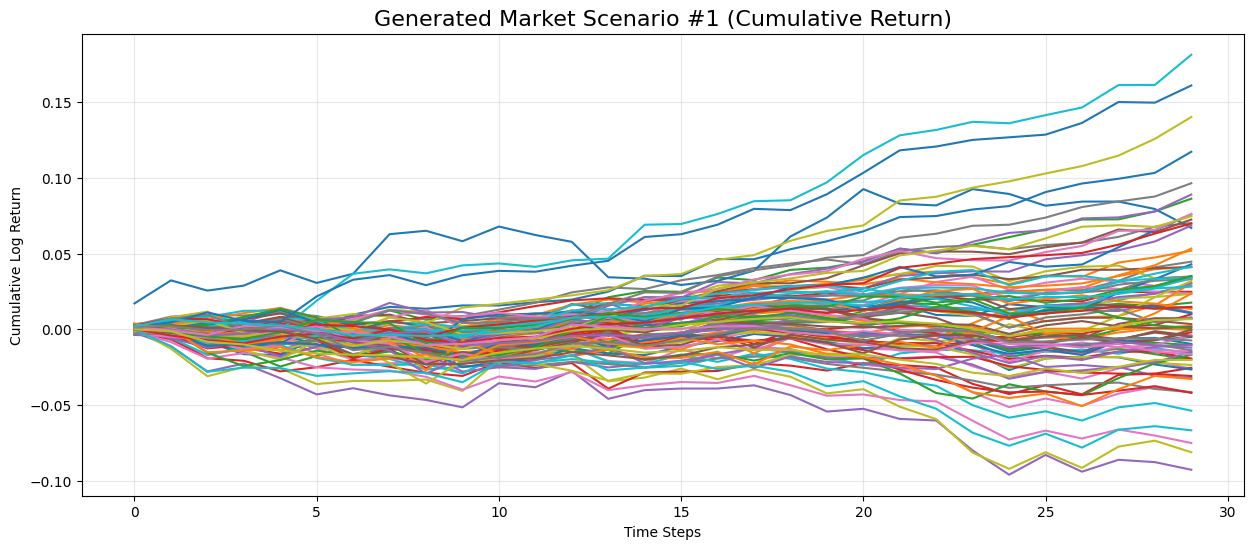

In [108]:
def generate_market_scenarios(config, encoder, decoder, dynamics, diffusion, n_scenarios=5):
    print("새로운 시장 시나리오 생성 시작...")

    # 1. 초기 노이즈 생성 (가상의 팩터 공간)
    # Shape: (n_scenarios, k, T)
    # 완전한 무작위 노이즈에서 시작합니다.
    x_t = torch.randn(n_scenarios, config.num_factors, config.steps).to(device)

    # 2. 역방향 확산 (Reverse Diffusion)
    # 노이즈 -> 의미 있는 팩터로 변환 (Denoising)
    # 실제로는 수십~수백 스텝을 거쳐야 하지만, 여기선 Dynamics 모델이
    # "노이즈 낀 팩터"를 보고 "원본 팩터"를 한 방에 예측하도록 학습했으므로 한 번에 갑니다.
    # (DDIM이나 다른 Sampler를 쓰면 더 정교하지만, 일단 One-step으로 확인)

    with torch.no_grad():
        # 임의의 시점 t (여기서는 노이즈가 가득 찬 상태라 가정)에서 원본 추론
        # 더 정교한 샘플링을 위해선 t를 줄여가는 루프가 필요하지만,
        # 현재 구조(Dynamics가 f_0_hat을 직접 예측)상 바로 통과시켜 봅니다.

        # t값은 모델에게 "이거 노이즈 얼마나 낀거야?"를 알려주는 용도
        # 여기선 완전 노이즈 상태(T)라고 가정
        t = torch.ones(n_scenarios, device=device).long() * (config.steps - 1)

        # Dynamics: 노이즈 팩터 -> 정제된 가상 팩터
        generated_factors = dynamics(x_t, t)

        # Decoder: 가상 팩터 -> 가상 주가(Log Return)
        generated_returns = decoder(generated_factors) /100# (N, D, T)

    # 3. 시각화 (Cumsum으로 주가 경로 만들기)
    gen_np = generated_returns.cpu().numpy()

    plt.figure(figsize=(15, 6))

    # 첫 번째 시나리오의 5개 종목만 그려봅니다.
    scenario_idx = 0
    assets_to_plot = np.arange(0,90,1)

    for asset_idx in assets_to_plot:
        # 로그 수익률 -> 누적 수익률(주가 경로) 변환
        price_path = np.cumsum(gen_np[scenario_idx, asset_idx, :])
        plt.plot(price_path, label=f'Virtual Stock {asset_idx}')

    plt.title(f"Generated Market Scenario #{scenario_idx+1} (Cumulative Return)", fontsize=16)
    plt.xlabel("Time Steps")
    plt.ylabel("Cumulative Log Return")
    plt.grid(True, alpha=0.3)
    plt.show() #
    return generated_returns

# 실행
gen_data = generate_market_scenarios(config, encoder, decoder, dynamics, diffusion)

🚀 Asset #0에 대한 3000개 시나리오 생성 및 통계 분석 중...

 [Asset #0 Simulation Statistics (N=3000)]
 ------------------------------------------------
 ▶ Mean (평균 수익률)   : 0.0395
 ▶ Std  (변동성)        : 0.0348
 ▶ Skewness (왜도)      : -0.0608  (음수면 하락 꼬리가 )
 ▶ Kurtosis (첨도)      : 0.0570  (양수면 뚱뚱한 꼬리/Fat-tail)


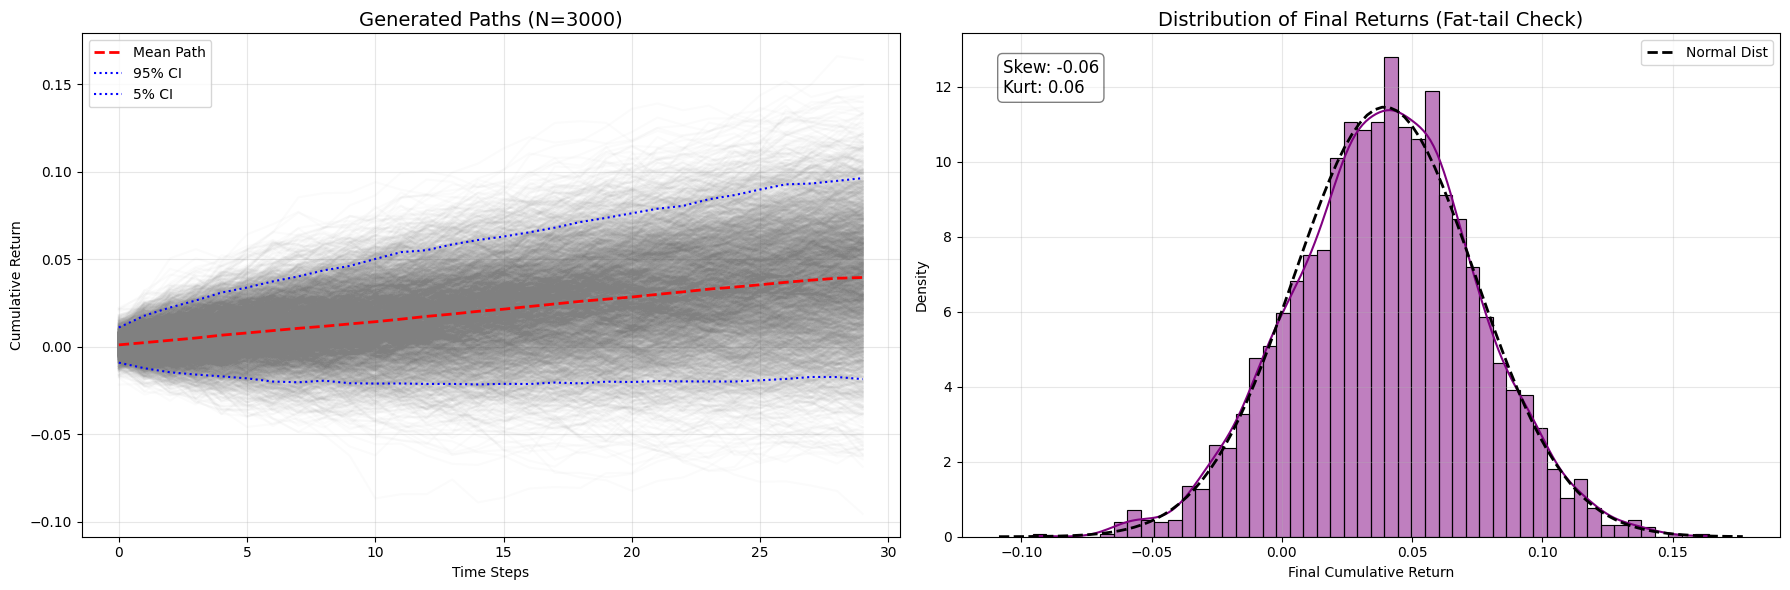

In [115]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns

def analyze_single_asset_simulation(config, decoder, dynamics, device,
                                    target_asset_idx=0, n_scenarios=1000, scale_factor=100.0):
    print(f"🚀 Asset #{target_asset_idx}에 대한 {n_scenarios}개 시나리오 생성 및 통계 분석 중...")

    decoder.eval()
    dynamics.eval()

    # 1. 1000개의 시나리오를 위한 Latent Noise 생성
    # (1000, k, T)
    z = torch.randn(n_scenarios, config.num_factors, config.steps).to(device)

    # 2. Diffusion Process (Reverse)
    # Dynamics 모델을 통해 Noise -> Latent Factors 변환
    # [수정됨] config.num_timesteps 대신 config.steps 사용
    # 여기서는 One-step prediction을 가정하므로 마지막 스텝(T-1)을 입력으로 줍니다.
    t = torch.ones(n_scenarios, device=device).long() * (config.steps - 1)

    with torch.no_grad():
        generated_factors = dynamics(z, t)
        generated_returns = decoder(generated_factors) # (1000, D, T)

    # 3. 데이터 추출 및 스케일링 원복 (Log Return 단위로 변환)
    # (1000, T)
    asset_returns = generated_returns[:, target_asset_idx, :].cpu().numpy() / scale_factor

    # 4. 누적 수익률(Price Path) 변환
    # (1000, T)
    asset_paths = np.cumsum(asset_returns, axis=1)

    # 5. 최종 수익률 분포 추출 (마지막 시점의 누적 수익률)
    final_returns = asset_paths[:, -1]

    # ---------------------------------------------------------
    # 통계적 지표 계산 (Skewness, Kurtosis)
    # ---------------------------------------------------------
    # Fisher=True: 정규분포의 첨도를 0으로 맞춤 (Excess Kurtosis)
    # 금융 데이터는 보통 0보다 큰 값(Fat-tail)을 가져야 정상입니다.
    sk = skew(final_returns)
    ku = kurtosis(final_returns, fisher=True)

    mu = np.mean(final_returns)
    sigma = np.std(final_returns)

    print("\n" + "="*50)
    print(f" [Asset #{target_asset_idx} Simulation Statistics (N={n_scenarios})]")
    print(f" ------------------------------------------------")
    print(f" ▶ Mean (평균 수익률)   : {mu:.4f}")
    print(f" ▶ Std  (변동성)        : {sigma:.4f}")
    print(f" ▶ Skewness (왜도)      : {sk:.4f}  (음수면 하락 꼬리가 )")
    print(f" ▶ Kurtosis (첨도)      : {ku:.4f}  (양수면 뚱뚱한 꼬리/Fat-tail)")
    print("="*50)

    # ---------------------------------------------------------
    # 시각화 (좌: 시나리오 경로 / 우: 최종 수익률 분포)
    # ---------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # [왼쪽] 시나리오 경로 (Spaghetti Plot)
    # 1000개 다 그리면 떡지니까 투명도(alpha)를 아주 낮게 줍니다.
    axes[0].plot(asset_paths.T, color='gray', alpha=0.03)
    axes[0].plot(np.mean(asset_paths, axis=0), color='red', linewidth=2, linestyle='--', label='Mean Path')

    # 신뢰구간 (95%, 5%)
    axes[0].plot(np.percentile(asset_paths, 95, axis=0), color='blue', linestyle=':', label='95% CI')
    axes[0].plot(np.percentile(asset_paths, 5, axis=0), color='blue', linestyle=':', label='5% CI')

    axes[0].set_title(f"Generated Paths (N={n_scenarios})", fontsize=14)
    axes[0].set_xlabel("Time Steps")
    axes[0].set_ylabel("Cumulative Return")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper left')

    # [오른쪽] 최종 수익률 분포 (Histogram & KDE)
    sns.histplot(final_returns, bins=50, kde=True, color='purple', ax=axes[1], stat='density')

    # 정규분포 곡선 추가 (비교용)
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2)
    axes[1].plot(x, p, 'k--', linewidth=2, label='Normal Dist')

    # 텍스트로 통계치 표시
    stats_text = f"Skew: {sk:.2f}\nKurt: {ku:.2f}"
    axes[1].text(0.05, 0.95, stats_text, transform=axes[1].transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axes[1].set_title(f"Distribution of Final Returns (Fat-tail Check)", fontsize=14)
    axes[1].set_xlabel("Final Cumulative Return")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 실행 (Asset 0번에 대해 1000개 시나리오)
analyze_single_asset_simulation(config, decoder, dynamics, device,
                                target_asset_idx=0, n_scenarios=3000, scale_factor=100.0)